<a href="https://colab.research.google.com/github/yesufsa/PersonalInterestProject/blob/main/wine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
df = pd.read_csv("wine.csv", usecols = ["country", "description", "points", "price", "variety", "winery"])
df.head()

,country,description,points,price,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,96,235.0,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",96,110.0,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,96,90.0,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",96,65.0,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",95,66.0,Provence red blend,Domaine de la Bégude


In [ ]:
df = df.dropna(subset = ["description", "points"])

In [ ]:
df.head()

,country,description,points,price,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,96,235.0,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",96,110.0,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,96,90.0,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",96,65.0,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",95,66.0,Provence red blend,Domaine de la Bégude


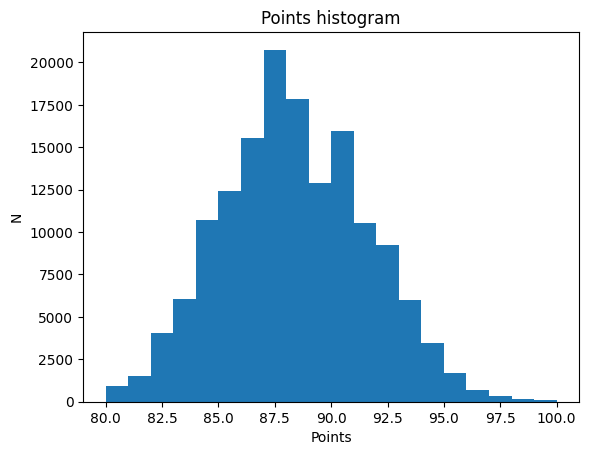

In [ ]:
plt.hist(df.points, bins=20)
plt.title("Points histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [ ]:
df["label"]  = (df.points >= 90).astype(int)
df = df[["description", "label"]]

In [ ]:
df.head()

,description,label
0,This tremendous 100% varietal wine hails from ...,1
1,"Ripe aromas of fig, blackberry and cassis are ...",1
2,Mac Watson honors the memory of a wine once ma...,1
3,"This spent 20 months in 30% new French oak, an...",1
4,"This is the top wine from La Bégude, named aft...",1


In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [ ]:
len(train), len(val), len(test)

(120744, 15093, 15093)

In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [ ]:
list(train_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b"Dry, lush and soft, with richly extracted black currant, beef jerky, sweet milk chocolate and anise flavors that go on and on. Has a prickly, peppery feeling that's a little hot.",
        b'Dryness and herba notes mark this wine. Despite some rich oak influences, it comes down on the mineral and sage side, only vaguely suggesting fruitier notes of pineapples and peaches.',
        b'93-95 Barrel sample. Certainly on the dry side, the wine is very rich, hard edged in its spiciness, with quite a bite of ginger. The acidity, though, is very much in balance, offering a wonderful crispness at the core of all the sweetness.',
        ...,
        b'Earthy up front, with a heavy, mildly herbal set of berry aromas. The palate is juicy and fairly solid, with fresh red-berry flavors accented by a dose of creamy vanilla. Long on the finish for basic Merlot, with an herbal lasting impression.',
        b'Dark and tannic, this is a wine wi

In [ ]:
embedding = hub.load("https://www.kaggle.com/models/google/nnlm/TensorFlow2/en-dim50/1")
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable = True)

In [ ]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.43799475, -0.07667544,  0.05766688, ...,  0.12000014,
        -0.0677143 , -0.06616226],
       [ 0.14514962, -0.07837568, -0.00380661, ...,  0.17254004,
        -0.08350698, -0.06487737],
       [ 0.31217918, -0.14879434,  0.04385841, ...,  0.03319928,
        -0.20710133, -0.02097498],
       ...,
       [ 0.22006099, -0.12534723,  0.00839672, ..., -0.0462009 ,
        -0.10549421,  0.21101429],
       [ 0.38620582, -0.17617536, -0.0840306 , ..., -0.07994393,
        -0.31141582,  0.06941514],
       [ 0.41581526, -0.17648688,  0.19106302, ...,  0.02092384,
         0.15014097,  0.38713908]], dtype=float32)>

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.evaluate(train_data)

118/118 [==============================] - 2s 15ms/step - loss: 0.6672 - accuracy: 0.6624


[0.6671856641769409, 0.6623931527137756]

In [ ]:
model.evaluate(valid_data)

15/15 [==============================] - 0s 21ms/step - loss: 0.6670 - accuracy: 0.6636


[0.6669861674308777, 0.6636189222335815]

In [ ]:
history = model.fit(train_data, epochs = 10, validation_data = valid_data)

Epoch 1/10
118/118 [==============================] - 206s 2s/step - loss: 0.5707 - accuracy: 0.6877 - val_loss: 0.4322 - val_accuracy: 0.8114
Epoch 2/10
118/118 [==============================] - 192s 2s/step - loss: 0.4084 - accuracy: 0.8124 - val_loss: 0.3514 - val_accuracy: 0.8460
Epoch 3/10
118/118 [==============================] - 198s 2s/step - loss: 0.3443 - accuracy: 0.8562 - val_loss: 0.3277 - val_accuracy: 0.8559
Epoch 4/10
118/118 [==============================] - 165s 1s/step - loss: 0.3074 - accuracy: 0.8776 - val_loss: 0.3187 - val_accuracy: 0.8629
Epoch 5/10
118/118 [==============================] - 166s 1s/step - loss: 0.2832 - accuracy: 0.8891 - val_loss: 0.3184 - val_accuracy: 0.8688
Epoch 6/10
118/118 [==============================] - 167s 1s/step - loss: 0.2604 - accuracy: 0.8985 - val_loss: 0.3132 - val_accuracy: 0.8723
Epoch 7/10
118/118 [==============================] - 165s 1s/step - loss: 0.2422 - accuracy: 0.9060 - val_loss: 0.3133 - val_accuracy: 0.8742

#LSTM (Yet to be finished)